In [1]:
!pip install scikit-learn

Model performance on TEST:
  R^2   : 1.000
  MAE   : 0.000
  RMSE  : 0.000

Approx. standardized coefficients (higher magnitude => stronger influence):
          feature          coef
6       pos_count  2.633024e+01
8       neu_count  3.492454e-01
2   avg_len_words  1.100691e-13
9       pos_ratio  6.691201e-16
10      neg_ratio  3.182081e-16
4   weekend_share -2.495780e-16
5     active_days -2.582946e-15
11     lag1_score -7.809171e-15
3   max_len_words -2.476058e-13
1   avg_len_chars -9.789305e-13
0       msg_count -1.280550e+01
7       neg_count -3.948499e+01


c:\Users\aryan\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


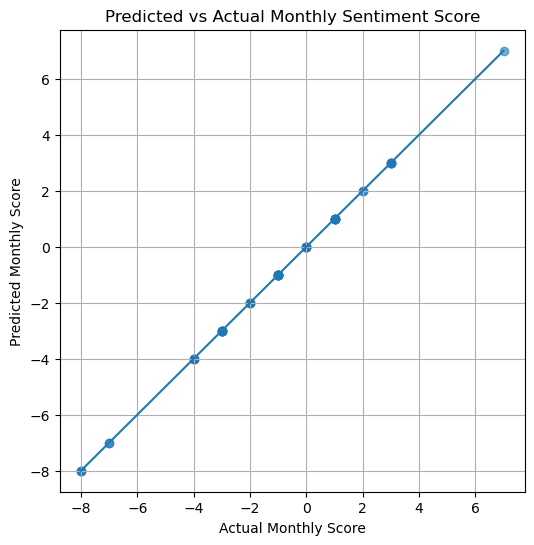


Saved: monthly_score_predictions_test.csv


In [ ]:


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt


df = pd.read_csv("test(in)_with_sentiment.csv")

# Ensure datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Guard: drop rows without date or from
df = df.dropna(subset=['date', 'from'])

# Make a safe text column to measure length on
txt = df['text'].fillna(df['Subject'].fillna('') + " " + df['body'].fillna('')).fillna('')
df['text_used'] = txt

# Map per-message sentiment to numeric (same mapping as Task 3)
score_map = {'Positive': 1, 'Negative': -1, 'Neutral': 0}
df['msg_score'] = df['sentiment'].map(score_map).fillna(0).astype(int)

# ------------------------------------
# 2) Build employee–month feature table
# ------------------------------------
df['YearMonth'] = df['date'].dt.to_period('M')
df['is_weekend'] = df['date'].dt.dayofweek >= 5  # Sat/Sun

# Basic per-message text lengths
df['len_chars'] = df['text_used'].str.len()
df['len_words'] = df['text_used'].str.split().apply(len)

# Aggregations per employee–month
agg = {
    'msg_score': ['sum', 'count'],
    'len_chars': ['mean'],
    'len_words': ['mean', 'max'],
    'is_weekend': ['mean'],
    'date': [lambda s: s.dt.date.nunique()]
}

monthly = df.groupby(['from', 'YearMonth']).agg(agg)
monthly.columns = [
    'score_sum', 'msg_count',
    'avg_len_chars',
    'avg_len_words', 'max_len_words',
    'weekend_share',
    'active_days'
]
monthly = monthly.reset_index()

# Sentiment distribution features
sent_ct = df.pivot_table(index=['from','YearMonth'], columns='sentiment', values='text_used', aggfunc='count', fill_value=0)
for c in ['Positive','Negative','Neutral']:
    if c not in sent_ct.columns:
        sent_ct[c] = 0
sent_ct = sent_ct.reset_index().rename(columns={
    'Positive':'pos_count','Negative':'neg_count','Neutral':'neu_count'
})

# Join
feat = monthly.merge(sent_ct, on=['from','YearMonth'], how='left')

# Ratios 
feat['pos_ratio'] = feat['pos_count'] / feat['msg_count'].replace(0, np.nan)
feat['neg_ratio'] = feat['neg_count'] / feat['msg_count'].replace(0, np.nan)
feat['pos_ratio'] = feat['pos_ratio'].fillna(0.0)
feat['neg_ratio'] = feat['neg_ratio'].fillna(0.0)

# Target
feat['target_score'] = feat['score_sum']

# ---------------------------------------------
# 3) Add a lag feature 
# ---------------------------------------------
feat = feat.sort_values(['from','YearMonth'])
feat['lag1_score'] = (
    feat.groupby('from')['target_score']
        .shift(1)
        .fillna(0)  # if no previous month, set 0
)


feat['YearMonth'] = feat['YearMonth'].astype(str)
periods_sorted = sorted(feat['YearMonth'].unique())
# Use last 20% of months as test
cut = int(np.floor(len(periods_sorted) * 0.8))
train_months = set(periods_sorted[:cut])
test_months  = set(periods_sorted[cut:])

train_df = feat[feat['YearMonth'].isin(train_months)].copy()
test_df  = feat[feat['YearMonth'].isin(test_months)].copy()


feature_cols = [
    'msg_count', 'avg_len_chars', 'avg_len_words', 'max_len_words',
    'weekend_share', 'active_days',
    'pos_count', 'neg_count', 'neu_count',
    'pos_ratio', 'neg_ratio',
    'lag1_score'
]
X_train = train_df[feature_cols].fillna(0)
y_train = train_df['target_score'].values

X_test = test_df[feature_cols].fillna(0)
y_test = test_df['target_score'].values

# Scale numeric features
preprocess = ColumnTransformer(
    transformers=[('num', StandardScaler(), feature_cols)],
    remainder='drop'
)

model = Pipeline(steps=[
    ('prep', preprocess),
    ('lin', LinearRegression())
])


model.fit(X_train, y_train)
pred = model.predict(X_test)

r2  = r2_score(y_test, pred)
mae = mean_absolute_error(y_test, pred)
rmse = mean_squared_error(y_test, pred, squared=False)

print("Model performance on TEST:")
print(f"  R^2   : {r2:.3f}")
print(f"  MAE   : {mae:.3f}")
print(f"  RMSE  : {rmse:.3f}")


lin = model.named_steps['lin']
scaler = model.named_steps['prep'].named_transformers_['num']

coefs = pd.DataFrame({
    'feature': feature_cols,
    'coef': lin.coef_ / scaler.transform(np.eye(len(feature_cols))).std(axis=0)
})
coefs = coefs.sort_values('coef', ascending=False)
print("\nApprox. standardized coefficients (higher magnitude => stronger influence):")
print(coefs)

# -------------------------
# 8) Plot Predicted vs Actual
# -------------------------
plt.figure(figsize=(6,6))
plt.scatter(y_test, pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()])
plt.xlabel("Actual Monthly Score")
plt.ylabel("Predicted Monthly Score")
plt.title("Predicted vs Actual Monthly Sentiment Score")
plt.grid(True)
plt.show()


out = test_df[['from','YearMonth','target_score']].copy()
out['pred_score'] = pred
out.to_csv("monthly_score_predictions_test.csv", index=False)
print("\nSaved: monthly_score_predictions_test.csv")


In [ ]:
#Predictive Modeling - Sentiment Trend Prediction

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset
df = pd.read_csv("test(in)_with_sentiment.csv")


df['date'] = pd.to_datetime(df['date'])

# Message length (chars)
df['msg_length'] = df['text'].astype(str).apply(len)

# Word count
df['word_count'] = df['text'].astype(str).apply(lambda x: len(x.split()))

# Messages per month (frequency per employee)
df['year_month'] = df['date'].dt.to_period('M')
msg_freq = df.groupby(['from', 'year_month'])['text'].count().reset_index(name='msg_freq')

# Merge back
df = df.merge(msg_freq, on=['from', 'year_month'], how='left')

# --- Sentiment Encoding ---
# Convert categorical sentiment → numeric score
sentiment_map = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
df['sentiment_score'] = df['sentiment'].map(sentiment_map)

# --- Select Features (X) & Target (y) ---
X = df[['msg_length', 'word_count', 'msg_freq']]
y = df['sentiment_score']

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Linear Regression Model ---
model = LinearRegression()
model.fit(X_train, y_train)

# --- Predictions ---
y_pred = model.predict(X_test)

# --- Evaluation ---
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("📊 Model Evaluation")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


coefficients = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_
}).sort_values(by="Coefficient", ascending=False)

print("\n🔑 Feature Importance:")
print(coefficients)



📊 Model Evaluation
RMSE: 0.9342
R² Score: 0.0252

🔑 Feature Importance:
      Feature  Coefficient
1  word_count     0.017398
2    msg_freq     0.002912
0  msg_length    -0.003073
